Задание 1 [4 балла].

Напишите функцию, на вход который поступает название города и которая выдает прогноз погоды на сегодня и завтра.
В прогноз включить температуру, осадки, влажность и скорость ветра.

In [1]:
def print_data(data_in):
    
    data = data_in["main"]
    print("======")
    print("Date: " + data_in['dt_txt'])
    
    print(f"Temperature: {int(data['temp'] - 273)} C")
    print("Weather info: " + data_in["weather"][0]["description"])
    
    print(f"Humidity: {data['humidity']} %")
    print(f"Wind speed: {data_in['wind']['speed']} knots")

In [2]:
import requests, json

API = "67ea3fcc7430f6af47a3bc3fcd22a5ab"

forecast_url = "http://api.openweathermap.org/data/2.5/forecast?"

city_name = input("Enter city name : ")

complete_forecast_url = forecast_url + "appid=" + API + "&q=" + city_name

forecast_response = requests.get(complete_forecast_url)

forecast = forecast_response.json()

if forecast["cod"] == "404":
    print("Got 404")
else:
    print("Forecast for " + city_name)
    for data in forecast['list'][:2]:
        print_data(data)

Enter city name : Moscow
Forecast for Moscow
Date: 2023-01-22 21:00:00
Temperature: -2 C
Weather info: overcast clouds
Humidity: 95 %
Wind speed: 1.95 knots
Date: 2023-01-23 00:00:00
Temperature: -3 C
Weather info: overcast clouds
Humidity: 96 %
Wind speed: 1.77 knots


Задание 2 [2 балла].

Воспользуйтесь рейтингом фильмов - https://www.imdb.com/chart/top
Выгрузите ранг фильма, название, год и рейтинг.
1. Определите самое успешное десятилетие на основе среднего и максимального рейтинга фильмов (например, десятилетием является период 2010-2019 включительно). Постройте график.
2. Выведите таблицу в формате: Десятилетие - Самый успешый фильм этого десятилетия

In [3]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import seaborn
from lxml import html
import matplotlib.pyplot as plt

C:\Users\Elf\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Elf\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Elf\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

In [5]:
movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

data_frame = {
    "movies": movies,
    "ratings": ratings,
    "links": links
}

data = pd.DataFrame(data_frame)

def get_title(text):
    data = text.get_text().split("\n")
    return data[2].strip()

def get_year(text):
    data = text.get_text().split("\n")
    return data[3].strip()[1:-1]

data["title"] = data.movies.apply(get_title)
data["year"] = data.movies.apply(get_year)
data = data.drop("movies", axis=1)
data.head()

,ratings,links,title,year
0,9.23534029440667,/title/tt0111161/,Побег из Шоушенка,1994
1,9.155960973719392,/title/tt0068646/,Крёстный отец,1972
2,8.990401159549073,/title/tt0468569/,Темный рыцарь,2008
3,8.983924551861154,/title/tt0071562/,Крёстный отец 2,1974
4,8.951809321931066,/title/tt0050083/,12 рaзгневанных мужчин,1957


In [6]:
data = data.sort_values("year")

period_length = 10
start_year = int(min(data["year"]))
end_year = int(max(data["year"]))

data.head()

,ratings,links,title,year
127,8.191866061259732,/title/tt0012349/,Малыш,1921
194,8.067954682511841,/title/tt0015324/,Шерлок младший,1924
176,8.084555202927227,/title/tt0015864/,The Gold Rush,1925
186,8.075876914368473,/title/tt0017925/,Паровоз Генерал,1926
115,8.220778705335993,/title/tt0017136/,Метрополис,1927


In [7]:
year_range = end_year - start_year
modulo = year_range % period_length

if modulo == 0:
    final_start = end_year - period_length
else:
    final_start = end_year - modulo
final_end = end_year + 1

starts = np.arange(start_year, final_start, period_length).tolist()

tuples = [(start, start+period_length) for start in starts]

tuples.append(tuple([final_start, final_end]))
bins = pd.IntervalIndex.from_tuples(tuples, closed='left')

In [8]:
original_labels = list(bins.astype(str))
new_labels = ['{} - {}'.format(b.strip('[)').split(', ')[0], int(b.strip('[)').split(', ')[1])-1) for b in original_labels]
label_dict = dict(zip(original_labels, new_labels))

In [9]:
# Assign each row to a period
data['period'] = pd.cut(data['year'].astype(int), bins=bins, include_lowest=True, precision=0)
data['period'] = data['period'].astype("str")
data.ratings = data.ratings.astype(float)
data.replace(label_dict)

,ratings,links,title,year,period
127,8.191866,/title/tt0012349/,Малыш,1921,1921 - 1930
194,8.067955,/title/tt0015324/,Шерлок младший,1924,1921 - 1930
176,8.084555,/title/tt0015864/,The Gold Rush,1925,1921 - 1930
186,8.075877,/title/tt0017925/,Паровоз Генерал,1926,1921 - 1930
115,8.220779,/title/tt0017136/,Метрополис,1927,1921 - 1930
...,...,...,...,...,...
129,8.181143,/title/tt10272386/,Отец,2020,2011 - 2020
107,8.234227,/title/tt8503618/,Гамильтон,2020,2011 - 2020
230,8.022441,/title/tt15097216/,Да прольётся свет,2021,2021 - 2022
147,8.141528,/title/tt10872600/,Человек-паук: Нет пути домой,2021,2021 - 2022


Period with highest mean:
          period   ratings
7  [1991, 2001)  8.349826


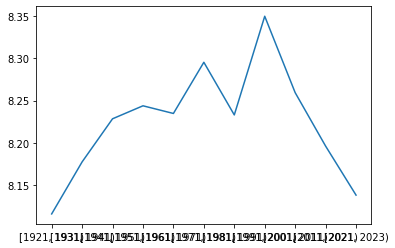

In [10]:
# Десятилетие через среднее
data_mean = data.groupby('period').mean().reset_index()
plt.plot(data_mean['period'], data_mean['ratings'])

print(f"Period with highest mean:\n {data_mean.iloc[[data_mean['ratings'].argmax()]]}")

Period with highest max:
          period   ratings
7  [1991, 2001)  8.349826


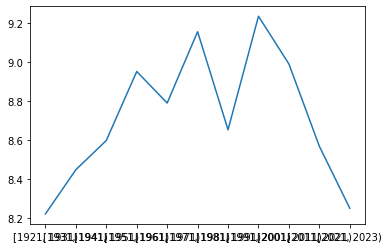

In [11]:
data_max = data.groupby('period').max().reset_index()
plt.plot(data_max['period'], data_max['ratings'])

print(f"Period with highest max:\n {data_mean.iloc[[data_max['ratings'].argmax()]]}")

In [12]:
# Лучший фильм под каждое десятилетие
data.groupby('period').max()

,ratings,links,title,year
period,,,,
"[1921, 1931)",8.220779,/title/tt0019254/,Шерлок младший,1928
"[1931, 1941)",8.447616,/title/tt0032976/,Это случилось однажды ночью,1940
"[1941, 1951)",8.597596,/title/tt0043014/,Эта замечательная жизнь,1950
"[1951, 1961)",8.951809,/title/tt0054215/,Четыреста ударов,1960
"[1961, 1971)",8.789955,/title/tt0064116/,"Хороший, плохой, злой",1968
"[1971, 1981)",9.155961,/title/tt0081505/,Чужой,1980
"[1981, 1991)",8.652684,/title/tt0099685/,Чужой 2,1990
"[1991, 2001)",9.235340,/title/tt0245712/,Шоу Трумана,2000
"[2001, 2011)",8.990401,/title/tt1375666/,Ходячий замок,2010


Задание 3 [4 балла].

Напишите скрипт, который будет нажимать на случайную внутреннюю ссылку на странице Википедии. Внутренней считается ссылка, которая ссылается на какую-то другую статью Википедии.
Ссылка должна быть из основного информационного блока. Функциональные ссылки из верхнего, бокового и нижнего меню в этой процедуре участвовать не должны.

На вход функции поступает число повторений этой процедуры. Переходы не прерываются, то есть при переходе на следующую статью следующая ссылка выбирается именно среди ссылок этой статьи.

Выведите путь (последовательность) по названиям статей, которые встретились в процессе перехода по страницам.

In [13]:
import requests
from bs4 import BeautifulSoup
import random

print("Enter number of iterations:")
N_ITER = int(input())
url = "https://ru.wikipedia.org/wiki/VK_(компания)"


for iter in range(N_ITER):
    response = requests.get(url=url,)
    soup = BeautifulSoup(response.content, 'html.parser')

    title = soup.find(id="firstHeading")
    if iter == N_ITER - 1:
        print(title.text)
    else:
        print(f"{title.text} ->\t")

    allLinks = soup.find(id="bodyContent").find_all("a")
    random.shuffle(allLinks)
    linkToScrape = 0

    for link in allLinks:
        # We are only interested in other wiki articles
        if link['href'].find("/wiki/") == -1: 
            continue

        # Use this link to scrape
        linkToScrape = link
        break

    url = "https://ru.wikipedia.org" + linkToScrape['href']

Enter number of iterations:
10
VK (компания) ->	
Skillbox ->	
Чистая прибыль ->	
EBITDA ->	
Категории ->	
Категория:1-й кабинет Кливленда ->	
Мэннинг, Дэниел ->	
Баярд, Томас Фрэнсис ->	
Фрелингуйсен, Фредерик Теодор ->	
Иглбергер, Лоуренс
